# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)

In [2]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import scipy.special #Used for additional plotting of MODFLOW data
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
from datetime import datetime #for dealing with datetime objects
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
from pyproj import Proj#Used for coordinate functions and re-mapping
import rasterio #For working with raster data and shapefiles

## Load External Data

Import the Galena Well Metadata  
Import the Sinkhole and Spring Data
Import precipitation Data  
Import Well Data  
Import DEM Data  
Import DTW in Galena Well

In [3]:
#Import the metadata for the Galena well
f = pl.Path('./data/galena_well_metadata_USGS.csv')
galena_df = pd.read_csv(f)

#Import the spring and sinkhole data
f = pl.Path("./data/karst_features.csv")
karst_df = pd.read_csv(f)
karst_df = karst_df.set_index("ID")# set the index for the karst_df dataframe tothe name of the feature ID 

#Set the path to the USGS datafile for the Galena (Marion RS) well
f = pl.Path("./data/galena_well_12_19_23_8_13_24_USGS.csv")

#Import the precipitation data
rain_df = pd.read_csv(f, usecols=['datetime', 'Precip_total_in']) #import the precipitation relevant columns
rain_df = rain_df.drop(rain_df.index[0]).reset_index(drop=True) # Drop the first row and reset the row index

#Import the Depth to water data
DTW_df = pd.read_csv(f, usecols = ['datetime', 'DTW_below_LSD']) #import the DTW relevant columns
DTW_df = DTW_df.drop(DTW_df.index[0]).reset_index(drop=True) # Drop the first row and reset the row index

#Import the Water Table Elevation Data (wtelev)
gwElev_df = pd.read_csv(f, usecols = ['datetime', 'GW_lvl_NAVD']) # import the wtelev relevant columns
gwElev_df = gwElev_df.drop(gwElev_df.index[0]).reset_index(drop=True) # Drop the first row and reset the row index

#Import water temperature data
gwTemp_df = pd.read_csv(f, usecols = ['datetime', 'Wtemp_C']) # import the temp relevant columns
gwTemp_df = gwTemp_df.drop(gwTemp_df.index[0]).reset_index(drop=True) #drop the first row and reset the row index


In [5]:
#create a fxn to return a dictionary of spring and sinkhole attributes
## This is used later to plot karst features
def get_karst_data(ID):
    return karst_df.loc[ID].to_dict()

#Test the above function
get_karst_data('55D54')

{'UTME': 558515, 'UTMN': 4867230, 'Elevation_ft': 1295, 'Type': 'sink'}

In [6]:
#Convert the galena well Latt and Long to UTM easting and UTM northing using NAD88
##(For SE Minnesota, the UTM zone is 15)
to_UTM = Proj(proj='utm', zone = 15, ellps='WGS84') #fxn toconvert the Latt/Long data into UTME and UTMN
galena_df['UTME'], galena_df['UTMN'] = to_UTM(galena_df['Long_NAD83'].values,galena_df['Lat_NAD83'].values )

#Convert the DTW, Precip, Water Table Elev. to meters
rain_df['Precip_total_in'] = pd.to_numeric(rain_df['Precip_total_in'], errors='coerce')  # Convert to numeric
rain_df['Precip_total_m'] = rain_df['Precip_total_in'] * 0.0254 #Conversion for inches into meters

DTW_df['DTW_below_LSD'] = pd.to_numeric(DTW_df['DTW_below_LSD'], errors = 'coerce') # Convert to numeric
DTW_df['DTW_below_LSD_m'] = DTW_df['DTW_below_LSD'] * 0.3048 # Convert ft to m

gwElev_df['GW_lvl_NAVD'] = pd.to_numeric(gwElev_df['GW_lvl_NAVD'], errors = 'coerce') #Convert to numeric
gwElev_df['GW_lvl_NAVD_m'] = gwElev_df['GW_lvl_NAVD'] * 0.3048 # Convert Ft to m

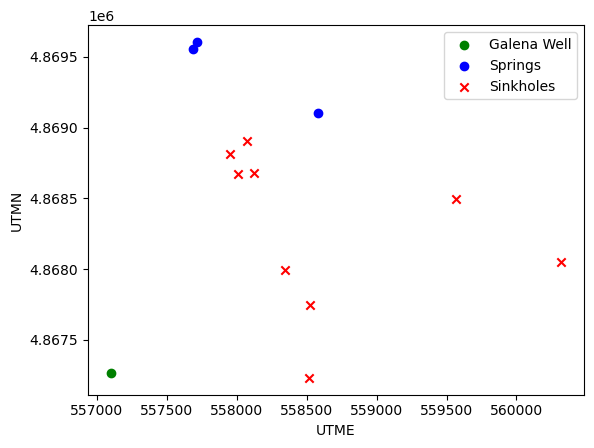

In [7]:
#Plot the location of the Galena well and Karst Features
# Assuming 'FeatureType' column differentiates springs and sinkholes in karst_df
springs = karst_df[karst_df['Type'] == 'spring']
sinkholes = karst_df[karst_df['Type'] == 'sink']

# Create a figure and axes
fig, ax = plt.subplots()

# Plot galena_df
ax.scatter(galena_df['UTME'], galena_df['UTMN'], color='green', label='Galena Well')

# Plot springs with green markers
ax.scatter(springs['UTME'], springs['UTMN'], color='blue', marker='o', label='Springs')

# Plot sinkholes with red markers
ax.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='red', marker='x', label='Sinkholes')

# Add labels and legend
ax.set_xlabel('UTME')
ax.set_ylabel('UTMN')
ax.legend()

# Show the plot
plt.show()

## Create the MODFLOW Model Grid

Place the grid onto real world coordinates for use with the DEM data and geological data

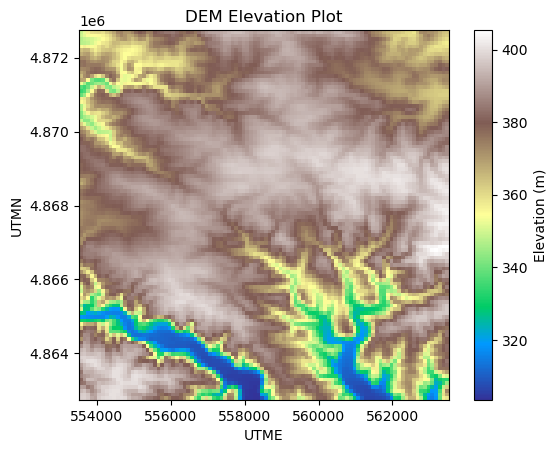

Current UTM Boundary: 553522.0
Current UTM Boundary: 563522.0
Current UTM Boundary: 4862747.0
Current UTM Boundary: 4872747.0


In [7]:
#Set the physical and grid boundaries of the model
Lx = 10000 #Width of the domain, m
Ly = 10000 #Length of the domain, m
nlay = 1 #Number of layers in the model
nrow = 100 #Number of rows
ncol = 100 #Number of columns
delr = Lx / ncol * np.ones(ncol, dtype =float) #set the cell width based on the domain and # of cells
delc = Ly / nrow * np.ones(nrow, dtype = float) #set the cell height based on domain and # of cells

#Import the DEM data and interpolate it so that it can be placed used in the MODFLOW model
#open the BIL file with DEM data
with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    
    #define the window of useful data (in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(553522.0, 563522.0, 4862747.0, 4872747.0, transform=src.transform)
    extent= rasterio.windows.bounds(window, src.transform) #Get window boundaries to confirm they are correct
    
    # Convert all of the data to a 100x100 grid, so it can be used in the MODFLOW model as the surface elev.
    width = ncol #set the width of the grid
    height = nrow #set the height of the grid
    transform = rasterio.transform.from_bounds(*extent, width, height) #Transform the data to the grid
    
    #Import the DEM and apply it to the grid
    dem_grid = src.read(
    1,
    out_shape = (height, width),
    window = window,
    resampling = rasterio.enums.Resampling.bilinear
    )
    
    #mask out the erroneous data (excessively large)
    maxval = 10000
    # Mask any values greater than the threshold, treating them as invalid
    dem_grid = np.ma.masked_where(dem_grid > maxval, dem_grid)
    
#Plot DEM as a colorplot to evaluate all of the values and establish the value range and units
plt.imshow(dem_grid, cmap='terrain', extent=extent)
plt.colorbar(label='Elevation (m)')
plt.xlabel('UTME')
plt.ylabel('UTMN')
plt.title('DEM Elevation Plot')
plt.show()

#print the boundary values of the DEM
for i in range(len(extent)):
    print(f'Current UTM Boundary: {extent[i]}')

#apply the DEM to the top grid of the model
top = dem_grid #create the top grid from the gridded DEM that was created from rasterio interpolation
botm = 250  #bottom row elevation in meters
botm = botm * np.ones((nlay, nrow, ncol), dtype=float) #create the bottom grid (will replace w/ decorah top)


Text(0, 0.5, 'Northing (m)')

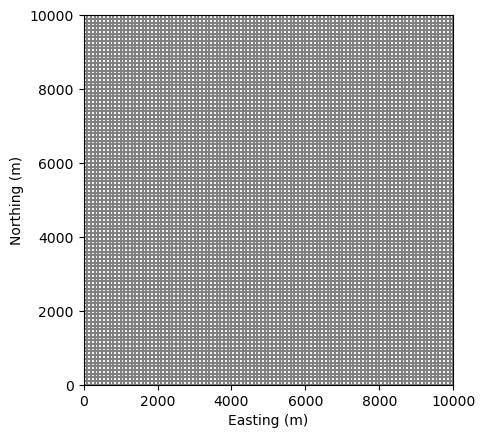

In [8]:
#Use the above parameters to create a modflow model grid
model_grid = flopy.discretization.StructuredGrid(
    delr = delr,
    delc = delc,
    top = top,
    botm = botm
)

#plot the grid produced by the above method
model_grid.plot()
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

The UTME Min and Max: (553522.0, 563522.0)
The UTMN Min and Max: (4862747.0, 4872747.0)


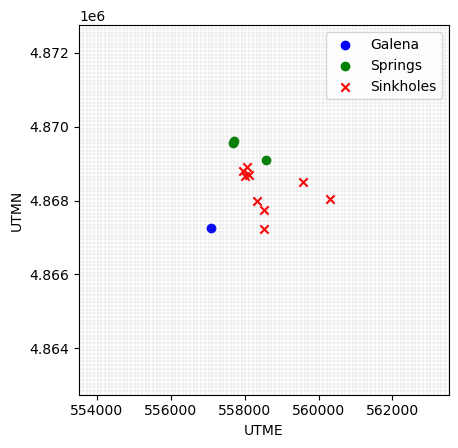

In [9]:
# Offset the grid onto the world coordinates available from the well data
# Calculate the offsets for the grid
grid_center_x , grid_center_y = karst_df.loc['55D810']['UTME'], karst_df.loc['55D810']['UTMN']
grid_length_x = delr.sum()
grid_length_y = delc.sum()
xoff = grid_center_x - 0.5 * grid_length_x
yoff = grid_center_y - 0.5 * grid_length_y

# Set grid coordinates using the offsets
model_grid.set_coord_info(xoff=xoff, yoff=yoff)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot galena_df wells
ax.scatter(galena_df['UTME'], galena_df['UTMN'], color='blue', label='Galena')

# Filter and plot springs with green markers
ax.scatter(springs['UTME'], springs['UTMN'], color='green', marker='o', label='Springs')

# Filter and plot sinkholes with red markers
ax.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='red', marker='x', label='Sinkholes')

# Plot the model grid on the same axes
model_grid.plot(ax=ax, lw=0.1)

# Add labels, legend, and grid
ax.set_xlabel('UTME')
ax.set_ylabel('UTMN')
ax.legend()
xlims = ax.get_xlim()
ylims = ax.get_ylim()
print(f'The UTME Min and Max: {xlims}')
print(f'The UTMN Min and Max: {ylims}')

# Show the plot
plt.show()

In [10]:
# Test that it is possible to get the row and column in the model for each of the features (wells, sinkholes, springs)
for name in ['55D810', '55D860', '55D861']:
    w = get_karst_data(name)
    i, j = model_grid.intersect(w['UTME'], w['UTMN'])
    print(name, i, j)

55D810 49 49
55D860 40 44
55D861 38 45


## Assign Aquifer Properties

** For the time being, only using a singular lay,

In [11]:
pl.Path.cwd()

PosixPath('/users/1/souce015/BearSpring/BearSpringUMN/EPM')